# Default settings

In [1]:
%run visualizations.ipynb
%pylab inline
import sys
from collections import Counter
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)
figsize(10,5)

## Get the hits

In [4]:
from hits import FlatHits

In [30]:
these_hits = FlatHits("../data/151212_SimChen_signal.root", prefix="M", branches=["M_volName", "M_volID","M_t", 
                                                                                  "M_hittype", "M_edep", 
                                                                                  "M_x", "M_y", "M_z",
                                                                                  "M_px", "M_py", "M_pz"])

In [5]:
# Quick and dirty volume grabbing
all_names = these_hits.volume_names
titles = ["Upstream Scintillator Hits", "Upstream Cherenkov Hits", "Upstream Cherenkov Light Guide Hits",\
          "Downstream Scintillator Hits", "Downstream Cherenkov Hits", "Downstream Cherenkov Light Guide Hits"]

In [31]:
print  list(set(these_hits.data["M_volName"]))

['TriCheLU', 'TriCheU', 'TriSciD', 'TriCheLD', 'TriCheD', 'TriSciU']


In [ ]:
for vol in list(set(these_hits.data["M_volName"])):
    vol_hits = these_hits.filter_hits(these_hits.data, "M_volName", vol)
    radius = np.sqrt(np.square(vol_hits["M_x"]) + np.square(vol_hits["M_y"]))
    z_pos = vol_hits["M_z"]
    print vol + " Centre is: " + str((max(radius) + min(radius))/2.)
    print vol + " Z is: " + str((max(z_pos) + min(z_pos))/2.)
    plt.hist(radius, bins=100, normed=True, color='red', alpha=0.5)
    plt.title(vol)
    plt.xlabel("Radius of Hit")
    plt.ylabel("Normalized Hits")
    show()
    plt.hist(z_pos, bins=100, normed=True, color='red', alpha=0.5)
    plt.title(vol)
    plt.xlabel("Z of Hits")
    plt.ylabel("Normalized Hits")
    show()

TriCheLU Centre is: 48.516615335
TriCheLU Z is: 582.1977


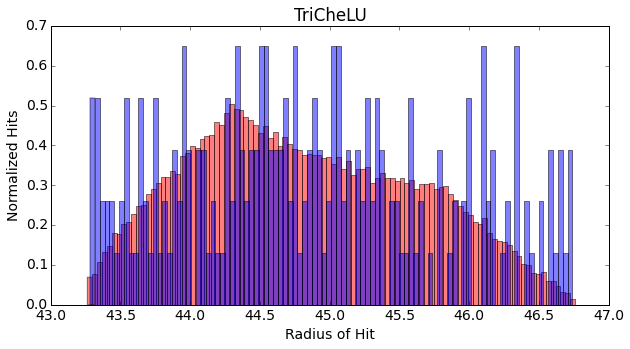

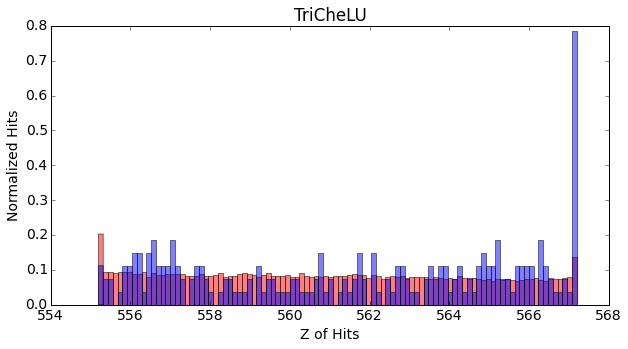

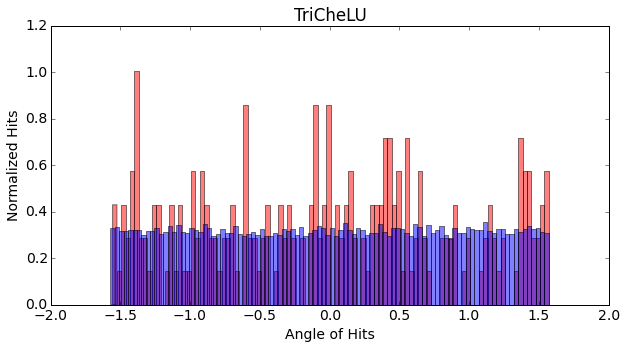

TriCheU Centre is: 48.516615335
TriCheU Z is: 582.1977


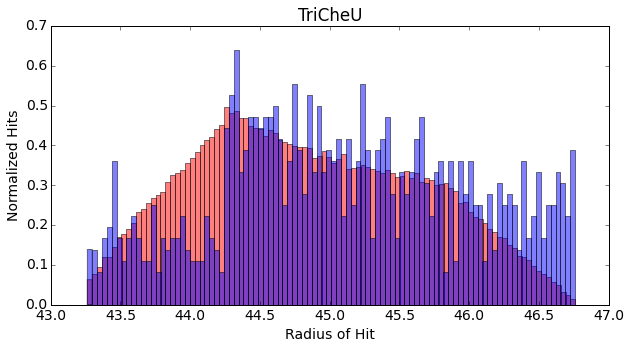

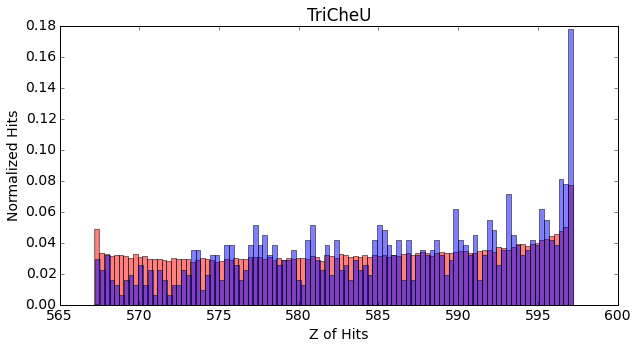

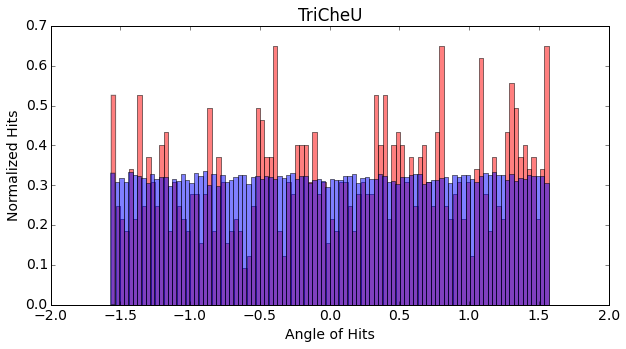

TriSciD Centre is: 48.516615335
TriSciD Z is: 582.1977


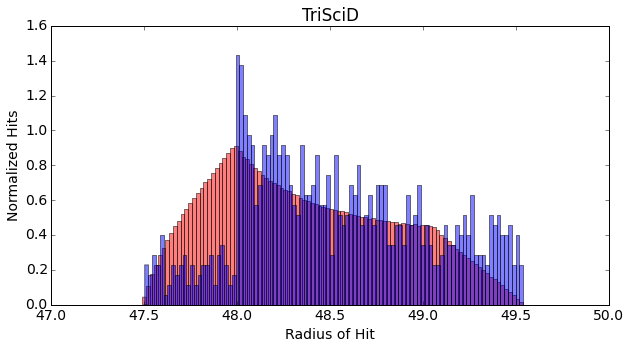

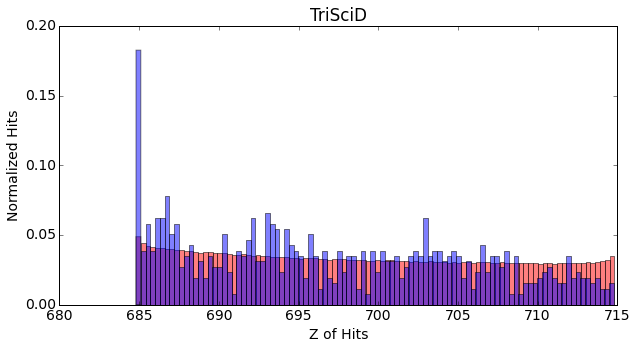

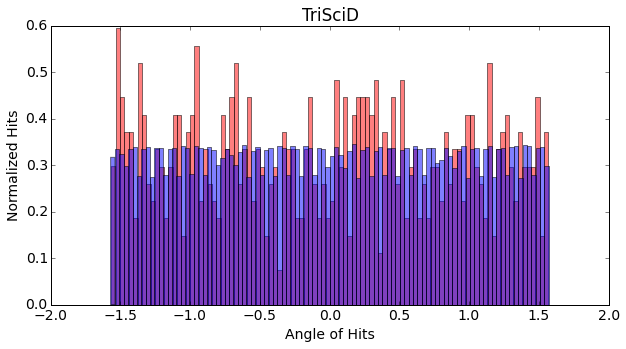

TriCheLD Centre is: 48.516615335
TriCheLD Z is: 582.1977

In [ ]:
sig_hits = these_hits.get_signal_hits()
bkg_hits = these_hits.get_background_hits()
for vol in list(set(these_hits.data["M_volName"])):
    vol_sig_hits = these_hits.filter_hits(sig_hits, "M_volName", vol)
    vol_bkg_hits = these_hits.filter_hits(bkg_hits, "M_volName", vol)

    sig_radius = np.sqrt(np.square(vol_sig_hits["M_x"]) + np.square(vol_sig_hits["M_y"]))
    bkg_radius = np.sqrt(np.square(vol_bkg_hits["M_x"]) + np.square(vol_bkg_hits["M_y"]))
    
    sig_z_pos = vol_sig_hits["M_z"]
    bkg_z_pos = vol_bkg_hits["M_z"]

    sig_angle = np.arctan(vol_sig_hits["M_y"]/vol_sig_hits["M_x"])
    bkg_angle = np.arctan(vol_bkg_hits["M_y"]/vol_bkg_hits["M_x"])

    
    print vol + " Centre is: " + str((max(radius) + min(radius))/2.)
    print vol + " Z is: " + str((max(z_pos) + min(z_pos))/2.)
    plt.hist(bkg_radius, bins=100, normed=True, color='red', alpha=0.5)
    plt.hist(sig_radius, bins=100, normed=True, color='blue', alpha=0.5)
    plt.title(vol)
    plt.xlabel("Radius of Hit")
    plt.ylabel("Normalized Hits")
    show()
    plt.hist(bkg_z_pos, bins=100, normed=True, color='red', alpha=0.5)
    plt.hist(sig_z_pos, bins=100, normed=True, color='blue', alpha=0.5)
    plt.title(vol)
    plt.xlabel("Z of Hits")
    plt.ylabel("Normalized Hits")
    show()
    plt.hist(sig_angle, bins=100, normed=True, color='red', alpha=0.5)
    plt.hist(bkg_angle, bins=100, normed=True, color='blue', alpha=0.5)
    plt.title(vol)
    plt.xlabel("Angle of Hits")
    plt.ylabel("Normalized Hits")
    show()

Number of Signal Hits : 223
Number of Background Hits : 78068


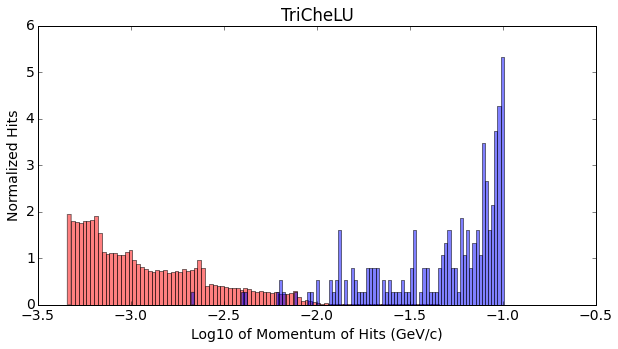

Number of Signal Hits : 1031
Number of Background Hits : 168129


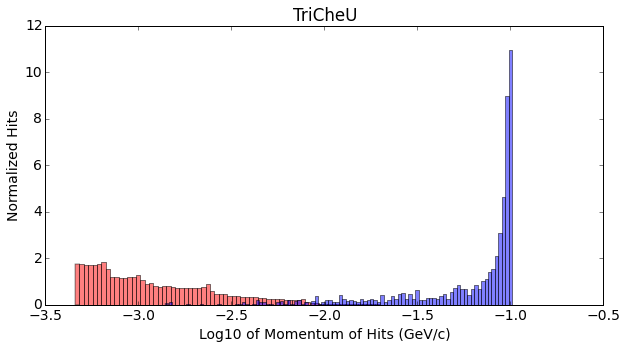

Number of Signal Hits : 859
Number of Background Hits : 2333241


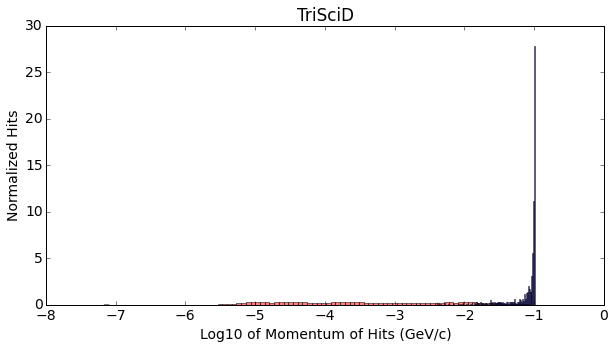

Number of Signal Hits : 419
Number of Background Hits : 206588


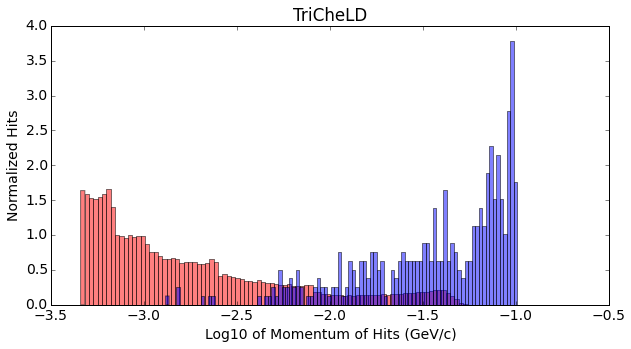

Number of Signal Hits : 1166
Number of Background Hits : 177066


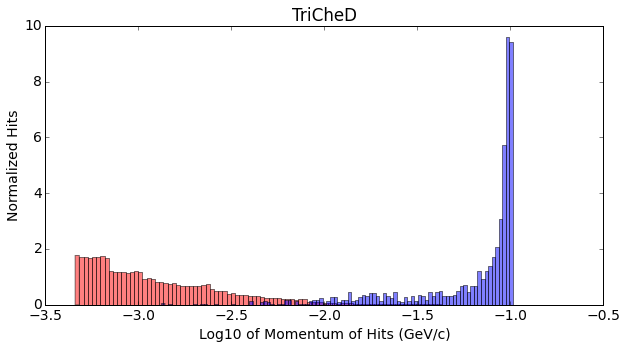

Number of Signal Hits : 629
Number of Background Hits : 3079204


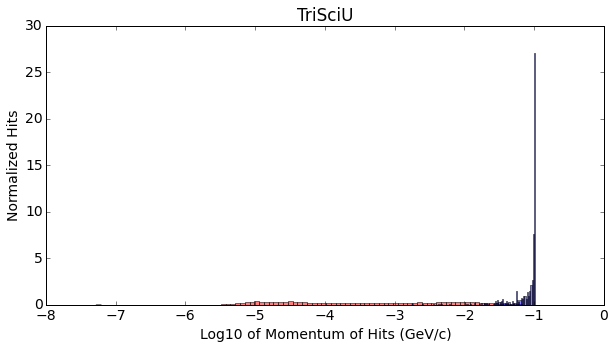

In [36]:
for vol in list(set(these_hits.data["M_volName"])):
    sig_hits = these_hits.get_signal_hits()
    bkg_hits = these_hits.get_background_hits()
    sig_hits = these_hits.filter_hits(sig_hits, "M_volName", vol)
    bkg_hits = these_hits.filter_hits(bkg_hits, "M_volName", vol)
    
    print "Number of Signal Hits : {}".format(len(sig_hits))
    print "Number of Background Hits : {}".format(len(bkg_hits))
    bkg_mom_amp = np.sqrt(np.square(bkg_hits["M_px"]) + np.square(bkg_hits["M_py"]) + np.square(bkg_hits["M_pz"]))
    sig_mom_amp = np.sqrt(np.square(sig_hits["M_px"]) + np.square(sig_hits["M_py"]) + np.square(sig_hits["M_pz"]))

    
    plt.hist(np.log10(bkg_mom_amp + 0.0000000001), bins=100, normed=True, color='red', alpha=0.5)
    plt.hist(np.log10(sig_mom_amp + 0.0000000001), bins=100, normed=True, color='blue', alpha=0.5)
    plt.title(vol)
    plt.xlabel("Log10 of Momentum of Hits (GeV/c)")
    plt.ylabel("Normalized Hits")
    plt.show()

Number of Signal Hits : 223
Number of Background Hits : 78068


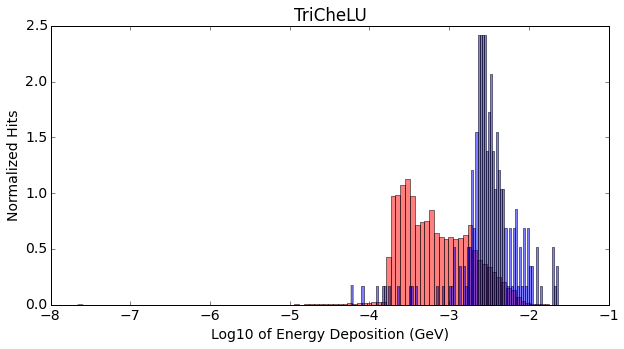

Number of Signal Hits : 1031
Number of Background Hits : 168129


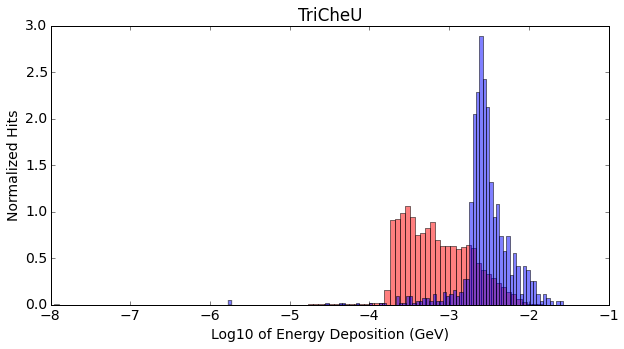

Number of Signal Hits : 859
Number of Background Hits : 2333241


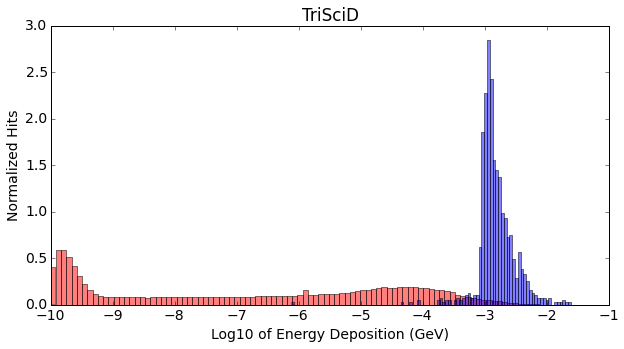

Number of Signal Hits : 419
Number of Background Hits : 206588


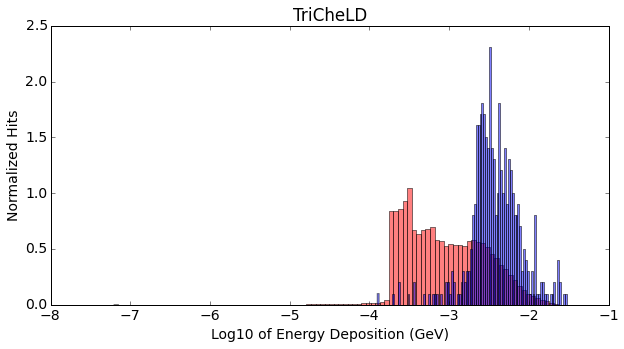

Number of Signal Hits : 1166
Number of Background Hits : 177066


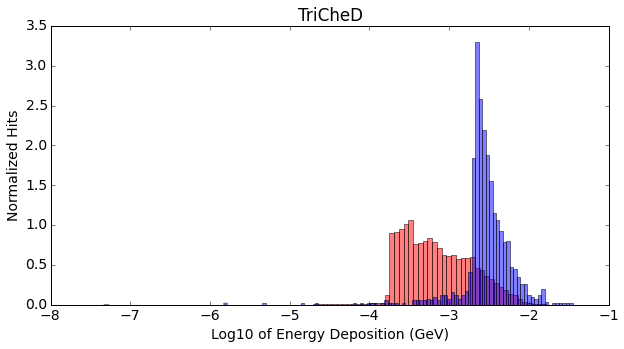

Number of Signal Hits : 629
Number of Background Hits : 3079204


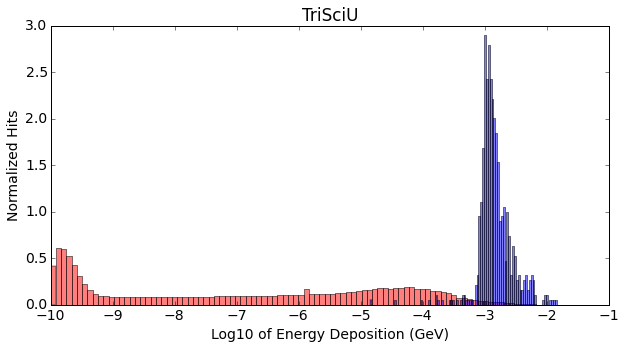

In [38]:
for vol in list(set(these_hits.data["M_volName"])):
    sig_hits = these_hits.get_signal_hits()
    bkg_hits = these_hits.get_background_hits()
    sig_hits = these_hits.filter_hits(sig_hits, "M_volName", vol)
    bkg_hits = these_hits.filter_hits(bkg_hits, "M_volName", vol)
    
    print "Number of Signal Hits : {}".format(len(sig_hits))
    print "Number of Background Hits : {}".format(len(bkg_hits))
    plt.hist(np.log10(bkg_hits["M_edep"] + 0.0000000001), bins=100, normed=True, color='red', alpha=0.5)
    plt.hist(np.log10(sig_hits["M_edep"] + 0.0000000001), bins=100, normed=True, color='blue', alpha=0.5)
    plt.title(vol)
    plt.xlabel("Log10 of Energy Deposition (GeV)")
    plt.ylabel("Normalized Hits")
    plt.show()

Number of Signal Hits : 223
Number of Background Hits : 78068


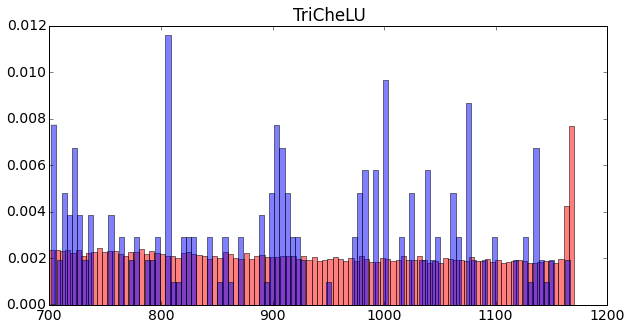

Number of Signal Hits : 1031
Number of Background Hits : 168129


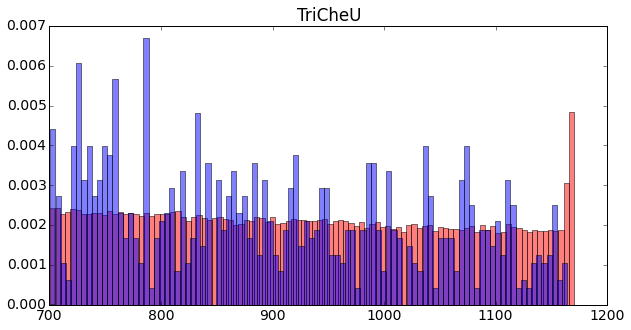

Number of Signal Hits : 859
Number of Background Hits : 2333241


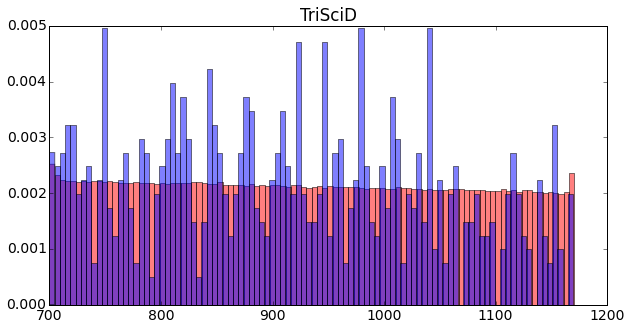

Number of Signal Hits : 419
Number of Background Hits : 206588


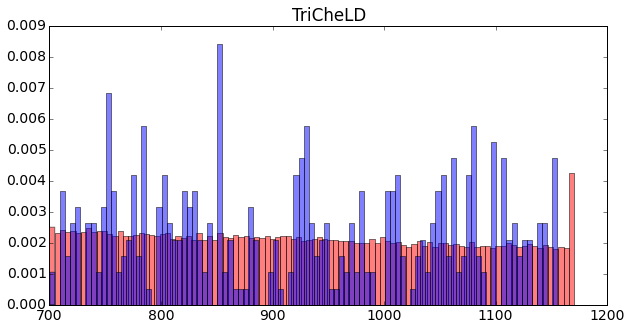

Number of Signal Hits : 1166
Number of Background Hits : 177066


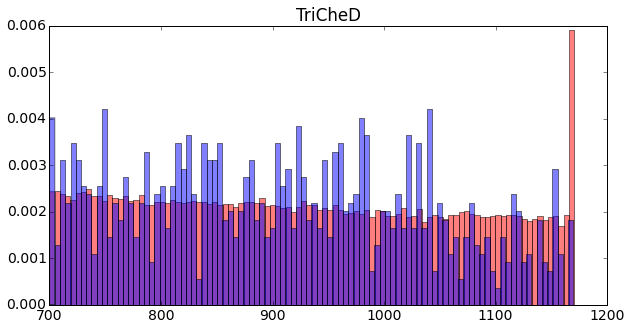

Number of Signal Hits : 629
Number of Background Hits : 3079204


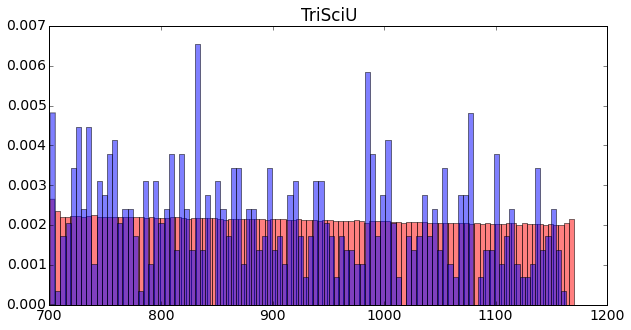

In [39]:
for vol in list(set(these_hits.data["M_volName"])):
    sig_hits = these_hits.get_signal_hits()
    bkg_hits = these_hits.get_background_hits()
    sig_hits = these_hits.filter_hits(sig_hits, "M_volName", vol)
    bkg_hits = these_hits.filter_hits(bkg_hits, "M_volName", vol)
    
    print "Number of Signal Hits : {}".format(len(sig_hits))
    print "Number of Background Hits : {}".format(len(bkg_hits))
    plt.hist(bkg_hits["M_t"], bins=100, normed=True, color='red', alpha=0.5)
    plt.hist(sig_hits["M_t"], bins=100, normed=True, color='blue', alpha=0.5)
    plt.title(vol)
    #plt.xlabel("Log10 of Energy Deposition (MeV)")
    #plt.ylabel("Normalized Hits")
    plt.show()

In [40]:
# Look at the number of signal hits typical to each volume
first_hit_by_vol = []
last_hit_by_vol = []
n_firsts = 0
n_lasts = 0
diff = 0
n_sigs = []
n_sig_evts = 0
for evt in range(these_hits.n_events):
    # Status bar
    if evt%1000 == 0:
        print evt,
    # Signal hits in the event
    evt_sig_hits = these_hits.get_signal_hits(events=evt)
    # Count how many we have
    n_sigs.append(len(evt_sig_hits))

0 1000 2000 3000 4000 5000


In [44]:
print "Number of Hits   Percentage of Events"
for key, value in zip(Counter(n_sigs).keys(), Counter(n_sigs).values()):
    print "{}                {:0.2}".format(key, value/float(these_hits.n_events))

Number of Hits   Percentage of Events
0                0.81
1                0.017
2                0.024
3                0.026
4                0.04
5                0.043
6                0.022
7                0.0082
8                0.003
9                0.0017
10                0.00035
